In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
# XGBoost 모델링을 위한 필수 라이브러리

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# SciKit Learn
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression


from xgboost import plot_importance
from xgboost import XGBClassifier

In [ ]:
# 모델 성능 계산을 위한 metrics 함수

def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

# 데이터 처리 및 탐색

In [ ]:
# 날씨, 토양도, 임상도, 산사태 발생 이력이 합쳐진 데이터 파일 불러오기
raw_df = pd.read_csv("merge_final_real.csv", encoding='utf-8-sig')

# 1일 후 예측과 2일 후 예측의 초기값은 0으로 설정
raw_df['1day_yn'] = 0.0
raw_df['2day_yn'] = 0.0

# 열을 밀어서 1일 후, 2일 후의 산사태 발생 여부를 표시
# 맨 첫날, 마지막 날의 경우 산사태가 발생하지 않음
raw_df['1day_yn'][1:-1] = raw_df['landslide'][0:-2]
raw_df['2day_yn'][2:-1] = raw_df['landslide'][0:-3]

In [ ]:
# 데이터프레임의 변수 중 Feature Importance를 통해 파악된 유의미한 변수만 사용

select_df = raw_df[['maxTa','minTa','avgTa','sumRn','maxInsWs','maxWs','avgWs','minRhm','avgRhm','LOCTN_ALTT','LOCTN_GRDN','1day_yn']]
cleaned_df_1 = select_df.fillna(0)

## 1일 후 예측

In [ ]:
# X, y 설정

y = cleaned_df_1['1day_yn']
X = cleaned_df_1.drop('1day_yn', axis =1)

In [ ]:
# 불균형한 데이터이므로 언더샘플링 기법을 활용하여 학습

from imblearn.under_sampling import RandomUnderSampler

# 예시는 1:20의 비율
X_samp, y_samp = RandomUnderSampler(random_state=1024, ratio={1: 359, 0: 7180}).fit_sample(X, y)

In [ ]:
# 훈련 데이터와 테스트 데이터를 0.75:0.25의 비율로 분할

X_train, X_test, y_train, y_test = train_test_split(X_samp, y_samp, test_size=0.25, shuffle=True, stratify=y_samp, random_state=0)

### 하이퍼 파라미터 튜닝 후 예측

In [ ]:
# XGBoost 하이퍼 파라미터 최적화

# 불균형한 데이터의 학습을 위해 scale_pos_weight 설정
xgb = XGBClassifier(scale_pos_weight=20)

# 하이퍼 파라미터 그리드
xgb_param_grid = {
    'n_estimators' : [100, 200, 400, 500, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth' : [4, 6, 8, 10, 12],
}

# GridSearchCV를 이용해 그리드 중에서 최적의 하이퍼 파라미터 값을 탐색
xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="roc_auc", n_jobs= 1, verbose = 1)
xgb_grid.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed: 12.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=20, seed=None,
                                     silent=None, subsample=1, verbosity=1),
             iid='deprecated', n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10, 12],
                         'n_estimators': [100, 

In [ ]:
print("최고 평균 auc : {0:.4f}".format(xgb_grid.best_score_))
print("최고의 파라미터 : ", xgb_grid.best_params_)
print("최고 점수를 낸 파라미터를 가진 모형 : ", xgb_grid.best_estimator_)

최고 평균 auc : 0.9936
최고의 파라미터 :  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
최고 점수를 낸 파라미터를 가진 모형 :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
# 하이퍼 파라미터 세팅 별 테스트 결과값 출력

result = pd.DataFrame(xgb_grid.cv_results_)
result.sort_values(by=['rank_test_score'], inplace=True)
result[['params', 'mean_test_score', 'rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
53,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.993576,1
52,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.993487,2
54,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.993428,3
77,"{'learning_rate': 0.15, 'max_depth': 4, 'n_est...",0.993396,4
51,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.993377,5
29,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.993300,6
28,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.993278,7
78,"{'learning_rate': 0.15, 'max_depth': 4, 'n_est...",0.993252,8
56,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.993248,9
115,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.993198,10


In [ ]:
# 최고의 테스트 결과를 보인 하이퍼 파라미터 값으로 모델 생성

xgb1 = xgb_grid.best_estimator_
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# 최적의 하이퍼 파라미터 값으로 모델 학습

xgb1 = XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4, scale_pos_weight=20)
evals = [(X_test, y_test)]
xgb1.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = 1)

In [ ]:
xgb1_pred = xgb1.predict(X_test)
metrics(y_test, xgb1_pred)

정확도 : 0.99, 정밀도 : 0.79, 재현율 : 0.98
f1-score : 0.88, auc : 0.98


# XGBoost 시각화 

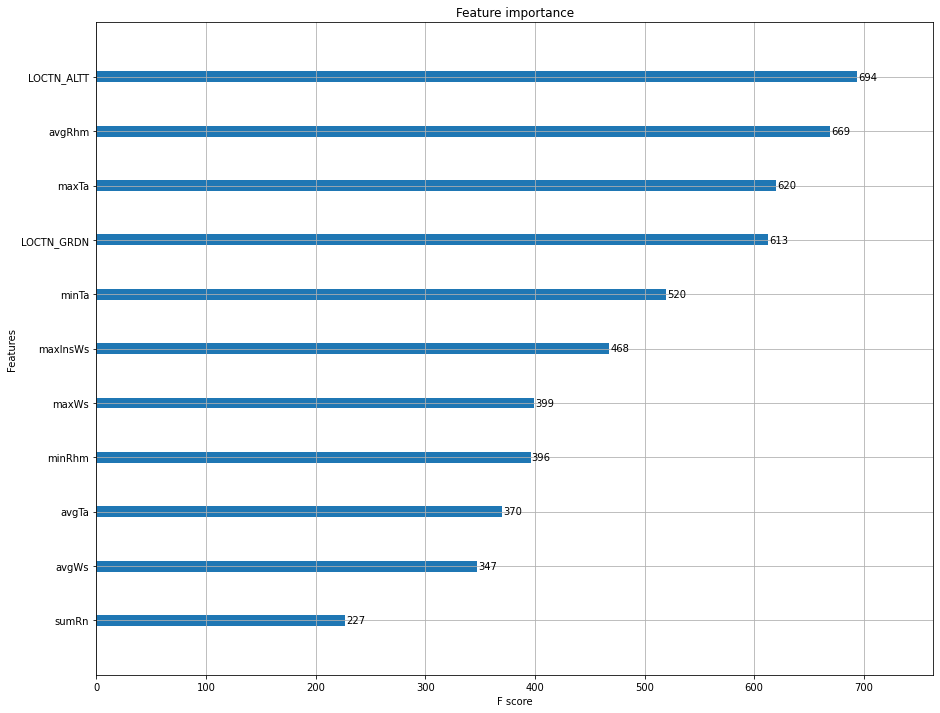

In [ ]:
import xgboost as xgb

# 각 변수 별 Feature Importance 출력
fig, ax = plt.subplots(figsize=(15,12))
plot_importance(xgb1, ax=ax)

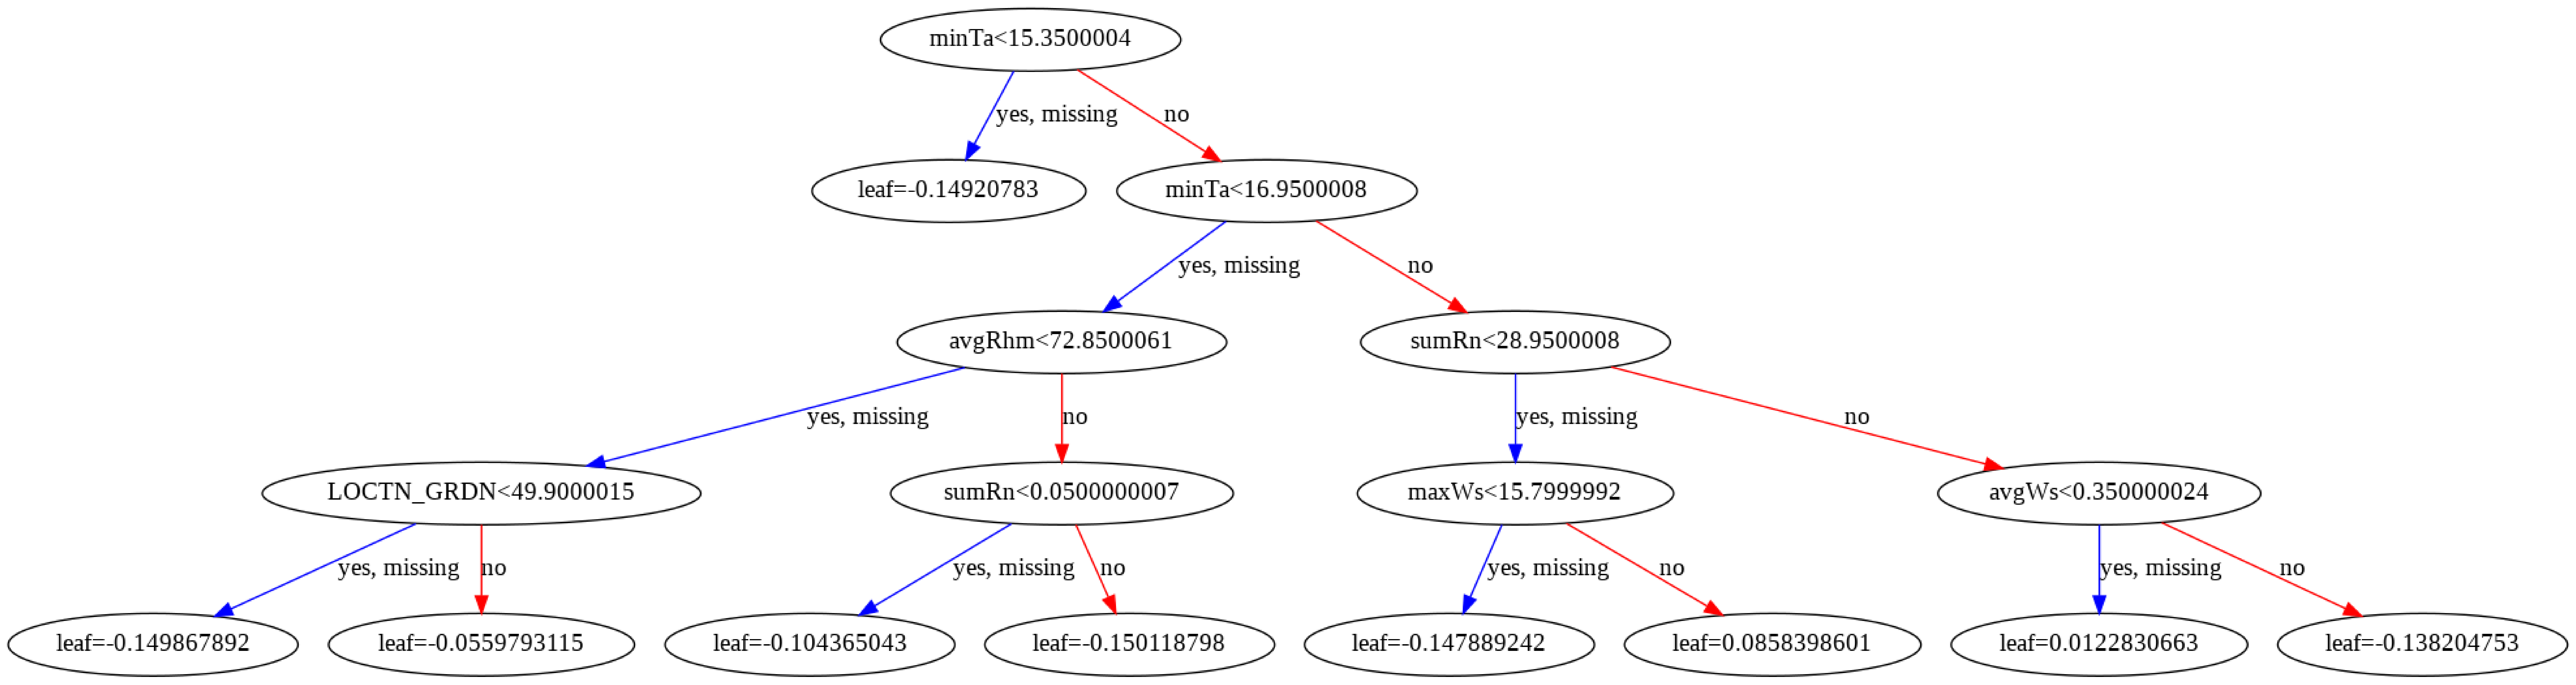

In [ ]:
# XGBoost 트리 구조 시각화

xgb.plot_tree(xgb1, num_trees=4)
fig = plt.gcf()
fig.set_size_inches(200, 150)
# fig.savefig('tree.png')

## 2일 후 예측

In [ ]:
# 데이터프레임의 변수 중 Feature Importance를 통해 파악된 유의미한 변수만 사용

select_df = raw_df[['maxTa','minTa','avgTa','sumRn','maxInsWs','maxWs','avgWs','minRhm','avgRhm','LOCTN_ALTT','LOCTN_GRDN','2day_yn']]
cleaned_df_2 = select_df.fillna(0)

In [ ]:
# X, y 설정

y = cleaned_df_2['2day_yn']
X = cleaned_df_2.drop('2day_yn', axis =1)

In [ ]:
# 1: 20 비율로 언더샘플링
X_samp, y_samp = RandomUnderSampler(random_state=1024, ratio={1: 359, 0: 7180}).fit_sample(X, y)

In [ ]:
# 훈련 데이터와 테스트 데이터를 0.75:0.25의 비율로 분할

X_train, X_test, y_train, y_test = train_test_split(X_samp, y_samp, test_size=0.25, shuffle=True, stratify=y_samp, random_state=1024)

In [ ]:
# XGBoost 하이퍼 파라미터 최적화

# 불균형한 데이터의 학습을 위해 scale_pos_weight 설정
xgb = XGBClassifier(scale_pos_weight=20)

# 하이퍼 파라미터 그리드
xgb_param_grid = {
    'n_estimators' : [100, 200, 400, 500, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth' : [4, 6, 8, 10, 12],
}

# GridSearchCV를 이용해 그리드 중에서 최적의 하이퍼 파라미터 값을 탐색
xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="roc_auc", n_jobs= 1, verbose = 1)
xgb_grid.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed: 14.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=20, seed=None,
                                     silent=None, subsample=1, verbosity=1),
             iid='deprecated', n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10, 12],
                         'n_estimators': [100, 

In [ ]:
print("최고 평균 auc : {0:.4f}".format(xgb_grid.best_score_))
print("최고의 파라미터 : ", xgb_grid.best_params_)
print("최고 점수를 낸 파라미터를 가진 모형 : ", xgb_grid.best_estimator_)

최고 평균 auc : 0.9906
최고의 파라미터 :  {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
최고 점수를 낸 파라미터를 가진 모형 :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
# 하이퍼 파라미터 세팅 별 테스트 결과값 출력

result = pd.DataFrame(xgb_grid.cv_results_)
result.sort_values(by=['rank_test_score'], inplace=True)
result[['params', 'mean_test_score', 'rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
35,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",0.990555,1
40,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.990442,2
17,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.990010,3
14,"{'learning_rate': 0.01, 'max_depth': 8, 'n_est...",0.990009,4
13,"{'learning_rate': 0.01, 'max_depth': 8, 'n_est...",0.989944,5
19,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.989816,6
31,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.989814,7
18,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.989748,8
45,"{'learning_rate': 0.05, 'max_depth': 12, 'n_es...",0.989737,9
36,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",0.989672,10


In [ ]:
# 최고의 테스트 결과를 보인 하이퍼 파라미터 값으로 모델 생성

xgb2 = xgb_grid.best_estimator_
xgb2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# 최적의 하이퍼 파라미터 값으로 모델 학습

xgb2 = XGBClassifier(n_estimators=100, learning_rate = 0.2, max_depth = 6, scale_pos_weight=19)
evals = [(X_test, y_test)]
xgb2.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = 1)

In [ ]:
xgb2_pred = xgb2.predict(X_test)
metrics(y_test, xgb2_pred)

정확도 : 0.98, 정밀도 : 0.68, 재현율 : 0.97
f1-score : 0.80, auc : 0.97


# 모델 검증 및 Submission 데이터 생성

In [ ]:
# Merged_data_file
Merged_2020 = pd.read_csv('../A2W/데이터/data_submission/merge_s_h_a20.csv')
# Test 검증 데이터셋
test_input = pd.read_csv('../A2W/데이터/data_submission/input.csv', encoding = 'cp949')

In [ ]:
# 1일 후 예측과 2일 후 예측을 위해 각 날짜와 읍면동 별 산사태 예측을 계산하는 함수

# 훈련된 모델로 결과 도출 : day1 함수
def day1_data_test(sgg, umd, date):    
    # sgg 데이터와 umd 데이터, date를 통한 추출
    text = sgg + ' ' + umd
    # specific 자체가 학습 돌린 결과 참고해서 input으로 만들어야 됨
    test_day1 = Merged_2020[Merged_2020['umd2'].str.contains(text.rstrip()) & Merged_2020['tm'].str.contains(date)]
    test_specific_day1 = test_day1[['maxTa','minTa','avgTa','sumRn','maxInsWs','maxWs','avgWs','minRhm','avgRhm','LOCTN_ALTT','LOCTN_GRDN']]
    fillna_test_specific_day1 = test_specific_day1.fillna(0)
    model_pred = xgb1.predict(fillna_test_specific_day1.to_numpy())
    return model_pred

# 훈련된 모델로 결과 도출 : day2 함수
def day2_data_test(sgg, umd, date):    
    # sgg 데이터와 umd 데이터, date를 통한 추출
    text = sgg + ' ' + umd
    # specific 자체가 학습 돌린 결과 참고해서 input으로 만들어야 됨
    test_day2 = Merged_2020[Merged_2020['umd2'].str.contains(text.rstrip()) & Merged_2020['tm'].str.contains(date)]
    test_specific_day2 = test_day2[['maxTa','minTa','avgTa','sumRn','maxInsWs','maxWs','avgWs','minRhm','avgRhm','LOCTN_ALTT','LOCTN_GRDN']]
    fillna_test_specific_day2 = test_specific_day2.fillna(0)
    model_pred = xgb2.predict(fillna_test_specific_day2.to_numpy())
    return model_pred

In [ ]:
# 검증 데이터를 이용하여 1일 후와 2일 후 산사태 예측

length_test_input = len(test_input.index)

#day_1 data
for index in range(length_test_input):
    if test_input['umd'][index] == "삼거동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상문동"
    elif test_input['umd'][index] == "어곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "강서동"
    elif test_input['umd'][index] == "주진동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "소주동"
    elif test_input['umd'][index] == "시동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "불국동"
    elif test_input['umd'][index] == "덕곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "지좌동"
    elif test_input['umd'][index] == "조와동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상망동"
    else:
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = test_input['umd'][index]
    test_input['1day_yn'][index] = day1_data_test(input_sgg, input_umd, input_date)
        

#day_2 data
for index in range(length_test_input):
    if test_input['umd'][index] == "삼거동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상문동"
    elif test_input['umd'][index] == "어곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "강서동"
    elif test_input['umd'][index] == "주진동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "소주동"
    elif test_input['umd'][index] == "시동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "불국동"
    elif test_input['umd'][index] == "덕곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "지좌동"
    elif test_input['umd'][index] == "조와동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상망동"  
    else:
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = test_input['umd'][index]
    test_input['2day_yn'][index] = day2_data_test(input_sgg, input_umd, input_date)


# test_input.head()

In [ ]:
# 1일 후 산사태 예측 결과 전체 3410개 데이터 중 96개가 산사태 발생

test_input["1day_yn"].value_counts()

0.0    3314
1.0      96
Name: 1day_yn, dtype: int64

In [ ]:
# 2일 후 산사태 예측 결과 전체 3410개 데이터 중 72개가 산사태 발생

test_input["2day_yn"].value_counts()

0.0    3338
1.0      72
Name: 2day_yn, dtype: int64

In [ ]:
# 검증 데이터프레임 출력

test_input.head()

,date,sd,sgg,umd,1day,1day_yn,2day,2day_yn
0,2020-06-10,경상남도,사천시,곤명면,2020-06-11,0.0,2020-06-12,0.0
1,2020-06-11,경상남도,사천시,곤명면,2020-06-12,0.0,2020-06-13,0.0
2,2020-06-12,경상남도,사천시,곤명면,2020-06-13,0.0,2020-06-14,0.0
3,2020-06-10,경상남도,사천시,곤양면,2020-06-11,0.0,2020-06-12,0.0
4,2020-06-11,경상남도,사천시,곤양면,2020-06-12,0.0,2020-06-13,0.0


In [ ]:
# 제출용 검증 데이터를 참가번호 명으로 저장

test_input.to_csv("210039.csv", index=False)